# Économétrie pure

On veut valider empiriquement l'équation suivante : 
$$\phi_{t}^{i} = \frac{1}{c_{\phi}^{i}}(P^{i}-A^{i}(E_{t}^{i}-\Psi_{t}^{i}))$$
Avec : 
- $\phi_{t}^{i}$: Flux mensuel de communication environnementale au mois $t$ pour l'entreprise $i$.
- $c_{t}^{i}$: Coût marginal de communication.
- $E_{t}^{i}$: Score environnemental au mois $t$ pour l'entreprise $i$.
- $\Psi_{t}^{i}$: Valeur environnementale fondamentale de l'entreprise $i$ au mois $t$.


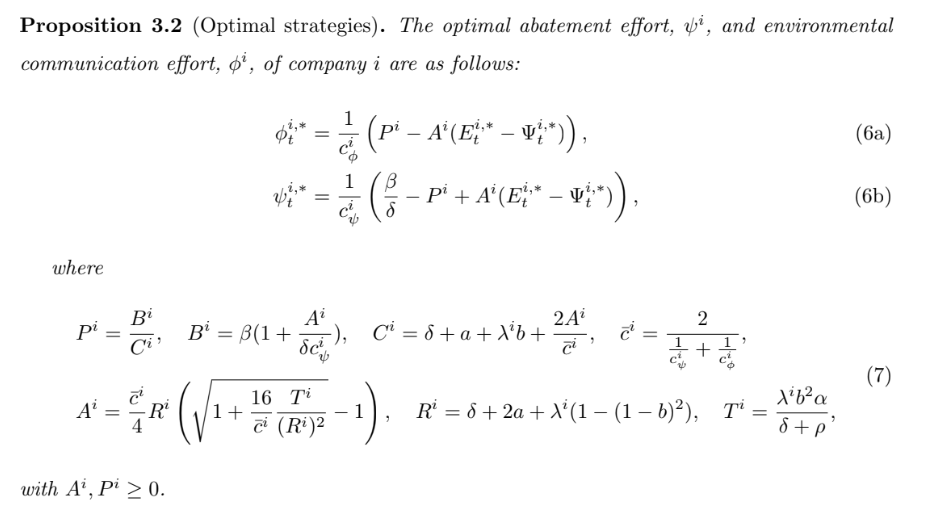

## 1st step

On cherche à construire un proxy $\hat{\phi}^{i}_{t}$ pour $\phi^{i}_{t}$. 


Nous construisons un score de communication environnementale, $\hat{\varepsilon}^{i}_{1,t}$, purifié de l'effet des controverses environnementales, défini comme les résidus de la régression Within de $Rep^{i}_{t}$ sur $Con^{i}_{t}$ avec des effets fixes dans le temps et pour l'entreprise, où $Con^{i}_{t}$ est instrumenté par $Con^{i}_{t-1}$ :
\begin{equation}
Rep^{i}_{t} = \alpha^{i}_{1,1} + \alpha_{1,2,t} + \beta_1 Con^{i,*}_{t} + \varepsilon^{i}_{1,t}
\end{equation}

où $Con^{i,*}_{t} = \hat{\beta}_2 Con^{i}_{t-1}$ est la prédiction de la régression suivante :
\begin{equation}
Con^{i}_{t} = \alpha^{i}_{2,1} + \alpha_{2,2,t} + \beta_2 Con^{i}_{t-1} + \varepsilon^{i}_{2,t}.
\end{equation}

--------------- TESTER PERTINENCE DE L'INSTRUMENT ----------------

Le test de pertinence de l'instrument $Con^{i}_{t}$ donne un $R^2$ de la régression de $Con^{i}_{t}$ sur $Con^{i}_{t-1}$ de 78,3\%. De plus, la condition d'exogénéité faible est satisfaite, assurant que les résidus de la régression 2SLS peuvent être utilisés pour construire un proxy du score de communication environnementale. Nous définissons alors un proxy du flux de communication environnementale, $\hat{\varphi}^{i}_{t}$, comme la première différence du score de communication environnementale :
\begin{equation}
\hat{\varphi}^{i}_{t} \equiv \hat{\varepsilon}^{i}_{1,t} - \hat{\varepsilon}^{i}_{1,t-1}.
\end{equation}

Ce proxy représente le flux de communication environnementale de l'entreprise i au mois t.

In [1]:
!pip3 install openpyxl
!pip3 install linearmodels
!pip3 install seaborn
import pandas as pd
import numpy as np
import linearmodels
import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.panel import PanelOLS, FirstDifferenceOLS, compare, RandomEffects

### Etape 1 : Construire la variable Con_star

#### Construction de Con_star

In [2]:
df = pd.read_pickle('data_pannels.pkl')

# Convertir la colonne 'Date' en type datetime
df['Date'] = pd.to_datetime(df['Date'])

df['ESG'] = df['ESG'].str.replace(',', '.').astype(float)


# Définir l'index sur les colonnes 'idEntreprise' et 'Date'
df.set_index(['idEntreprise', 'Date'], inplace=True)

df['Con_lag'] = df.groupby(level=0)['Controverse'].shift(1)

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag  
idEntreprise Date                                
116          2009-01-01    76.417500        NaN  
             2009-02-01    80.227281  76.417500  
             2009-03-01    70.353190  80.227281  
             2009-04-01    68.060606  70.353190  
             2009-05-01    60.100608  68.060606  
...                              ...        ...  
18970        2022-12-01     0.000000   0.000000  
             2023-01-01     0.000000   0.000000  
             2023-02-01     0.000000   0.000000  
             2023-03-01     0.000000   0.000000  
             2023-04-01     0.000000   0.000000  

[12212 rows x 6 columns]

In [3]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_fix = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_first_stage_fix = first_stage_fix.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_fix'] = res_first_stage_fix.fitted_values

df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag  Con_star_fix  
idEntreprise Date                                              
116          2009-01-01    76.417500        NaN           NaN  
             2009-02-01    80.227281  76.417500     65.342181  
             2009-03-01    70.353190  80.227281     68.599804  
             2009-04-01    68.060606  70.353190     60.156782  
             2009-05-01    60.100608  68.060606     58.196466  
...                              ...        ...           ...  
18970        2022-12-01     0.000000   0.000000      0.000000  
             2023-01-01     0.000000   0.000000      0.000000  
             2023-02-01     0.000000   0.000000      0.000000  
             2023-03-01     0.000000   0.000000      0.000000  
             2023-04-01     0.000000   0.000000      0.000000  

[12212 rows x 7 columns]

#### Analyse de Con_star et de sa régression

In [4]:
print(res_first_stage_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.7213
Estimator:                   PanelOLS   R-squared (Between):              0.9788
No. Observations:               12141   R-squared (Within):               0.7310
Date:                Sun, Apr 21 2024   R-squared (Overall):              0.9214
Time:                        10:13:14   Log-likelihood                -2.587e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    3.08e+04
Entities:                          71   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11899)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):           3.08e+04
                            

Voici une explication des principaux éléments de la sortie :

        La variable dépendante (Dep. Variable) est 'Controverse'.
        Le coefficient de détermination (R-squared) est de 0.7213, ce qui signifie que le modèle explique environ 72.13 % de la variance de la variable dépendante.
        Le R-squared (Between) représente la proportion de variance expliquée par les variations entre les entités.
        Le R-squared (Within) représente la proportion de variance expliquée par les variations à l'intérieur des entités.
        Le R-squared (Overall) représente la proportion de variance expliquée par le modèle dans son ensemble.

    Informations sur l'estimation :
        Le nombre d'observations est de 12141 (on perds des estimations à cause de l'effet within.

    Statistiques de test :
        Le F-statistic est utilisé pour tester la significativité globale du modèle. Ici, il est de 3.08e+04 avec un P-value de 0.0000, indiquant que le modèle dans son ensemble est statistiquement significatif.
        Le F-statistic (robust) est une version robuste du F-statistic qui est moins sensible aux violations des hypothèses de base de la régression linéaire.
        Le F-test for Poolability est utilisé pour tester la validité des effets fixes. Le P-value de ce test est également très faible (0.0000), ce qui suggère que les effets fixes sont statistiquement significatifs.

    Estimations des paramètres :
        Le coefficient de la variable explicative 'Con_lag' est de 0.8551. Cela signifie que, toutes choses égales par ailleurs, une augmentation d'une unité de 'Con_lag' est associée à une augmentation de 0.8551 unité de 'Controverse'.
        Les erreurs standard fournissent une indication de la précision des estimations des coefficients.
        Les valeurs de T-statistic et de P-value permettent de tester l'importance individuelle des coefficients. Ici, la P-value associée à 'Con_lag' est très faible (0.0000), indiquant que ce coefficient est statistiquement significatif.

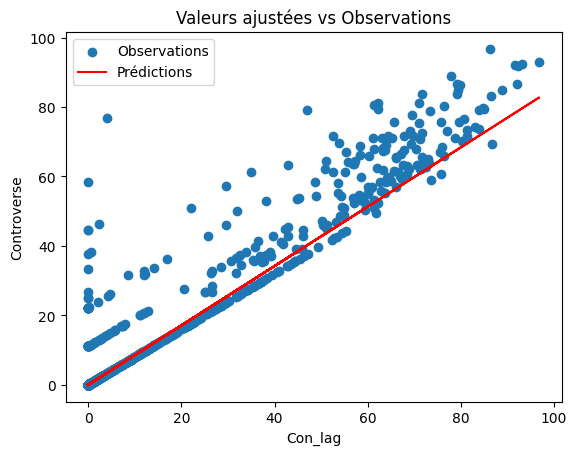

In [5]:
plt.scatter(df['Con_lag'], df['Controverse'], label='Observations')
plt.plot(df['Con_lag'], df['Con_star_fix'], color='red', label='Prédictions')
plt.xlabel('Con_lag')
plt.ylabel('Controverse')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [6]:
# Calcul des critères R2 ajustés, AIC et BIC à la main

# Calcul du R2 ajusté
n = res_first_stage_fix.nobs
k = res_first_stage_fix.df_model
r2 = res_first_stage_fix.rsquared
r2_adjusted_fix = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_fix = res_first_stage_fix.params.shape[0]
nobs_fix = res_first_stage_fix.nobs
resid_ss_fix = np.sum(res_first_stage_fix.resids ** 2)
aic_fix = 2 * num_params_fix - 2 * np.log(resid_ss_fix)
bic_fix = np.log(nobs_fix) * num_params_fix - 2 * np.log(resid_ss_fix)

print("R2 ajusté:", r2_adjusted_fix)
print("AIC:", aic_fix)
print("BIC:", bic_fix)

R2 ajusté: 0.715645660592753
AIC: -19.657055436569603
BIC: -12.252712003025628


Test de Hausman : Le test de Hausman est utilisé pour évaluer la spécification appropriée des modèles de régression dans lesquels il y a une incertitude sur le choix entre des effets fixes et des effets aléatoires. Plus spécifiquement, il est utilisé dans les modèles de panel pour déterminer si les effets fixes sont préférables aux effets aléatoires.

In [7]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['Controverse'], df[['Con_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_first_stage_fix, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                     Model Comparison                    
                           Effets Fixes Effets Aléatoires
---------------------------------------------------------
Dep. Variable               Controverse       Controverse
Estimator                      PanelOLS     RandomEffects
No. Observations                  12141             12141
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.7213            0.9342
R-Squared (Within)               0.7310            0.7197
R-Squared (Between)              0.9788            0.9989
R-Squared (Overall)              0.9214            0.9342
F-statistic                    3.08e+04         1.725e+05
P-value (F-stat)                 0.0000            0.0000
=====================     =============   ===============
Con_lag                          0.8551            0.9686
                               (175.49)          (415.32)
======================= =============== =================
Effects       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:2623: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


    Hypothèse Nulle (H0) : Les variables explicatives (exogènes) ne sont pas corrélées avec les effets spécifiques aux entités.

    Hypothèse Alternative (H1) : Les variables explicatives (exogènes) sont corrélées avec les effets spécifiques aux entités.

Statistique de test :

La statistique de test utilisée dans le test de Hausman est généralement basée sur la différence entre les estimateurs des effets fixes et des effets aléatoires. Cette statistique suit approximativement une distribution de chi carré sous l'hypothèse nulle.

In [8]:
from scipy.stats import chi2

def hausman_test(fe_model, re_model):
    b_fe = fe_model.params
    b_re = re_model.params
    v_fe = fe_model.cov
    v_re = re_model.cov
    
    b_diff = b_fe - b_re
    v_diff = v_fe - v_re
    
    hausman_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    df = b_diff.size
    
    p_value = chi2.sf(hausman_stat, df)
    
    return hausman_stat, p_value

# Suppose fe_model et re_model sont les résultats des modèles à effets fixes et à effets aléatoires respectivement
hausman_stat, p_value = hausman_test(res_first_stage_fix, res_random_effects)
print("Test de Hausman - Statistique : {:.4f}".format(hausman_stat))
print("Test de Hausman - P-valeur : {:.4f}".format(p_value))


Test de Hausman - Statistique : 704.2443
Test de Hausman - P-valeur : 0.0000


#### Construction de Con_star sans effet fixe

In [9]:
# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage_random = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=False, 
                       time_effects=True)
res_first_stage_random = first_stage_random.fit()

# Ajouter les valeurs ajustées à df
df['Con_star_random'] = res_first_stage_random.fitted_values

df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag  Con_star_fix  Con_star_random  
idEntreprise Date                                                               
116          2009-01-01    76.417500        NaN           NaN              NaN  
             2009-02-01    80.227281  76.417500     65.342181        73.909621  
             2009-03-01    70.353190  80.227281     68.599804        77.594373  
             2009-04-01    68.060606  70.353190     60.156782        68.044331  
             2009-05-01    60.100608  68.060606     58.196466        65.826985  
...                              ...        ...           ...              ...  
18970        2022-12-01     0.000000   0.000000      0.000000         0.000000  
             2023-01-01     0.000000   0.000000      0.000000         0.000000  
             2023-02-01     0.000000   0.000000      0.000000         0.000000  
             2023-03-01     0.000000   0.000000      0.000000         0.000000  
             2023-04-01     0.000000   0.000000      0.000000         0.000000  

[12212 rows x 8 columns]

In [10]:
print(res_first_stage_random)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.9324
Estimator:                   PanelOLS   R-squared (Between):              0.9989
No. Observations:               12141   R-squared (Within):               0.7200
Date:                Sun, Apr 21 2024   R-squared (Overall):              0.9342
Time:                        10:13:14   Log-likelihood                -2.621e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.652e+05
Entities:                          71   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11969)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          1.652e+05
                            

In [11]:
# Calcul des critères R2 ajusté, AIC et BIC à la main

n = res_first_stage_random.nobs
k = res_first_stage_random.df_model
r2 = res_first_stage_random.rsquared
r2_adjusted_random = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

num_params_random = res_first_stage_random.params.shape[0]
nobs_random = res_first_stage_random.nobs
resid_ss_random = np.sum(res_first_stage_random.resids ** 2)
aic_random = 2 * num_params_random - 2 * np.log(resid_ss_random)
bic_random = np.log(nobs_random) * num_params_random - 2 * np.log(resid_ss_random)

print("R2 ajusté:", r2_adjusted_random)
print("AIC:", aic_random)
print("BIC:", bic_random)

R2 ajusté: 0.9314641796421066
AIC: -19.769683440894966
BIC: -12.36534000735099


##### Résumé comparaison effet fixe et effet aléatoire

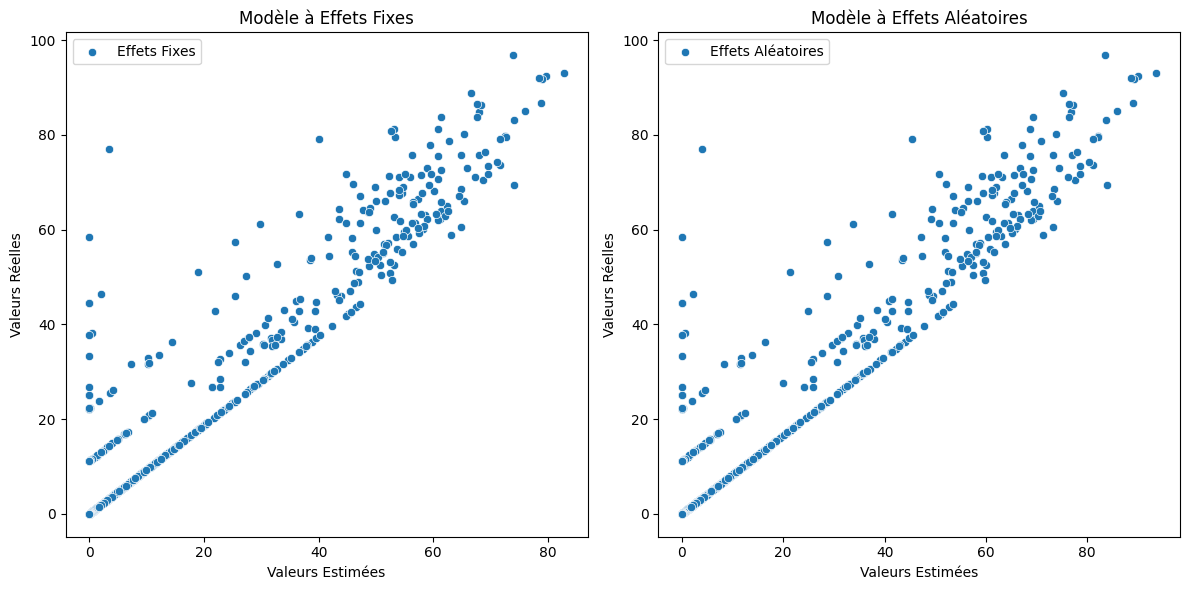

Comparaison des Performances :
-----------------------------------
           Modèle  R-squared ajusté        AIC        BIC  Nombre d'observations
     Effets Fixes          0.715646 -19.657055 -12.252712                  12141
Effets Aléatoires          0.931464 -19.769683 -12.365340                  12141


In [12]:
# R-squared
r2_adj_fixed = r2_adjusted_fix
r2_adj_random = r2_adjusted_random

# AIC
aic_fixed = aic_fix
aic_random = aic_random

# BIC
bic_fixed = bic_fix
bic_random = bic_random

# Nombre d'observations
nobs_fixed = nobs_fix
nobs_random = nobs_random

# 3. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=res_first_stage_fix.fitted_values.squeeze(), y=df['Controverse'], label='Effets Fixes')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Fixes')

plt.subplot(1, 2, 2)
sns.scatterplot(x=res_first_stage_random.fitted_values.squeeze(), y=df['Controverse'], label='Effets Aléatoires')
plt.xlabel('Valeurs Estimées')
plt.ylabel('Valeurs Réelles')
plt.title('Modèle à Effets Aléatoires')

plt.tight_layout()
plt.show()


# Création du tableau de comparaison des performances
performance_comparison = pd.DataFrame({
    'Modèle': ['Effets Fixes', 'Effets Aléatoires'],
    'R-squared ajusté': [r2_adj_fixed, r2_adj_random],
    'AIC': [aic_fixed, aic_random],
    'BIC': [bic_fixed, bic_random],
    'Nombre d\'observations': [nobs_fixed, nobs_random]
})

# Affichage du tableau
print("Comparaison des Performances :")
print("-----------------------------------")
performance_comparaison = performance_comparison.to_string(index=False)
print(performance_comparaison)

Conclusion : On a un meilleur R2 ajusté, AIC et BIC dans le modèle à effet aléatoire. En revanche, les tests nous affirme que l'effet fixe est préferable, donc on préfère prendre un modèle à effet fixe, tout en se rappelant que les critères d'informations semblaient dire l'inverse.

En somme, l'ajout d'un effet fixe dans le modèle ne semble pas améliorer grandement le modèle... ? Même si les test sont significatifs ?

In [13]:
df['Con_star'] = df['Con_star_fix']
df.drop(columns=['Con_star_fix','Con_star_random'], inplace=True)
df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  
idEntreprise Date                                           
116          2009-01-01    76.417500        NaN        NaN  
             2009-02-01    80.227281  76.417500  65.342181  
             2009-03-01    70.353190  80.227281  68.599804  
             2009-04-01    68.060606  70.353190  60.156782  
             2009-05-01    60.100608  68.060606  58.196466  
...                              ...        ...        ...  
18970        2022-12-01     0.000000   0.000000   0.000000  
             2023-01-01     0.000000   0.000000   0.000000  
             2023-02-01     0.000000   0.000000   0.000000  
             2023-03-01     0.000000   0.000000   0.000000  
             2023-04-01     0.000000   0.000000   0.000000  

[12212 rows x 7 columns]

### Etape 2 du 2SLS: 

In [14]:
# Seconde étape: Régression de PFL sur sur Con instrumenté par Con_star avec effets fixes
second_stage = PanelOLS(dependent=df['PFL'], 
                        exog=df[['Con_star']],
                        entity_effects=True, 
                        time_effects=True)
res_second_stage = second_stage.fit()

# Ajouter les valeurs ajustées à df
df['Rep_2SLS'] = res_second_stage.fitted_values
df['epsilon_hat'] = res_second_stage.resids

# Calcul du proxy du flux de communication environnementale
df['phi_hat'] = df.groupby(level=0)['epsilon_hat'].diff()

df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                      
116          2009-01-01    76.417500        NaN        NaN       NaN   
             2009-02-01    80.227281  76.417500  65.342181  0.350383   
             2009-03-01    70.353190  80.227281  68.599804  0.367851   
             2009-04-01    68.060606  70.353190  60.156782  0.322577   
             2009-05-01    60.100608  68.060606  58.196466  0.312066   
...                              ...        ...        ...       ...   
18970        2022-12-01     0.000000   0.000000   0.000000  0.000000   
             2023-01-01     0.000000   0.000000   0.000000  0.000000   
             2023-02-01     0.000000   0.000000   0.000000  0.000000   
             2023-03-01     0.000000   0.000000   0.000000  0.000000   
             2023-04-01     0.000000   0.000000   0.000000  0.000000   

                         epsilon_hat   phi_hat  
idEntreprise Date                               
116          2009-01-01          NaN       NaN  
             2009-02-01     2.130369       NaN  
             2009-03-01    -0.587864 -2.718233  
             2009-04-01    -0.342286  0.245578  
             2009-05-01     0.349807  0.692093  
...                              ...       ...  
18970        2022-12-01   -12.055445 -1.169986  
             2023-01-01   -12.060286 -0.004841  
             2023-02-01   -12.061130 -0.000844  
             2023-03-01   -12.374818 -0.313688  
             2023-04-01   -12.378358 -0.003539  

[12212 rows x 10 columns]

##### Analyse de la regression :

In [15]:
print(res_second_stage)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    PFL   R-squared:                     4.454e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0003
No. Observations:               12141   R-squared (Within):               0.0004
Date:                Sun, Apr 21 2024   R-squared (Overall):              0.0003
Time:                        10:13:16   Log-likelihood                -4.297e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0530
Entities:                          71   P-value                           0.8179
Avg Obs:                       171.00   Distribution:                 F(1,11899)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):             0.0530
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (PFL) expliquée par le modèle. Dans ce cas, le R² est de 0.1568, ce qui signifie que le modèle explique environ 15.68% de la variance de PFL.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 2213.2 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable instrumentée Con_star est estimé à 0.7994. Cela signifie que pour une augmentation d'une unité de Con_star, la variable PFL augmente en moyenne de 0.7994 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est statistiquement significatif, et la variable instrumentée Con_star a un effet positif significatif sur la variable PFL après avoir contrôlé les effets fixes des entités et des périodes de temps.

## 2nd step

### 1ère étape : Construction de ESG_star

In [16]:
df['ESG_lag'] = df.groupby(level=0)['ESG'].shift(1)

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                      
116          2009-01-01    76.417500        NaN        NaN       NaN   
             2009-02-01    80.227281  76.417500  65.342181  0.350383   
             2009-03-01    70.353190  80.227281  68.599804  0.367851   
             2009-04-01    68.060606  70.353190  60.156782  0.322577   
             2009-05-01    60.100608  68.060606  58.196466  0.312066   
...                              ...        ...        ...       ...   
18970        2022-12-01     0.000000   0.000000   0.000000  0.000000   
             2023-01-01     0.000000   0.000000   0.000000  0.000000   
             2023-02-01     0.000000   0.000000   0.000000  0.000000   
             2023-03-01     0.000000   0.000000   0.000000  0.000000   
             2023-04-01     0.000000   0.000000   0.000000  0.000000   

                         epsilon_hat   phi_hat    ESG_lag  
idEntreprise Date                                          
116          2009-01-01          NaN       NaN        NaN  
             2009-02-01     2.130369       NaN  82.539668  
             2009-03-01    -0.587864 -2.718233  82.542735  
             2009-04-01    -0.342286  0.245578  82.579781  
             2009-05-01     0.349807  0.692093  83.709127  
...                              ...       ...        ...  
18970        2022-12-01   -12.055445 -1.169986  51.447034  
             2023-01-01   -12.060286 -0.004841  51.443093  
             2023-02-01   -12.061130 -0.000844  51.439231  
             2023-03-01   -12.374818 -0.313688  51.435447  
             2023-04-01   -12.378358 -0.003539  51.431738  

[12212 rows x 11 columns]

In [17]:
# Première étape: Régression de ESG sur ESG_lag avec effets fixes
stage_one = PanelOLS(dependent=df['ESG'], 
                       exog=df[['ESG_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_stage_one = stage_one.fit()

# Ajouter les valeurs ajustées à df
df['ESG_star'] = res_stage_one.fitted_values

df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                      
116          2009-01-01    76.417500        NaN        NaN       NaN   
             2009-02-01    80.227281  76.417500  65.342181  0.350383   
             2009-03-01    70.353190  80.227281  68.599804  0.367851   
             2009-04-01    68.060606  70.353190  60.156782  0.322577   
             2009-05-01    60.100608  68.060606  58.196466  0.312066   
...                              ...        ...        ...       ...   
18970        2022-12-01     0.000000   0.000000   0.000000  0.000000   
             2023-01-01     0.000000   0.000000   0.000000  0.000000   
             2023-02-01     0.000000   0.000000   0.000000  0.000000   
             2023-03-01     0.000000   0.000000   0.000000  0.000000   
             2023-04-01     0.000000   0.000000   0.000000  0.000000   

                         epsilon_hat   phi_hat    ESG_lag   ESG_star  
idEntreprise Date                                                     
116          2009-01-01          NaN       NaN        NaN        NaN  
             2009-02-01     2.130369       NaN  82.539668  81.593674  
             2009-03-01    -0.587864 -2.718233  82.542735  81.596706  
             2009-04-01    -0.342286  0.245578  82.579781  81.633327  
             2009-05-01     0.349807  0.692093  83.709127  82.749730  
...                              ...       ...        ...        ...  
18970        2022-12-01   -12.055445 -1.169986  51.447034  50.857395  
             2023-01-01   -12.060286 -0.004841  51.443093  50.853499  
             2023-02-01   -12.061130 -0.000844  51.439231  50.849682  
             2023-03-01   -12.374818 -0.313688  51.435447  50.845941  
             2023-04-01   -12.378358 -0.003539  51.431738  50.842274  

[12212 rows x 12 columns]

#### Analyse de ESG_star et de sa régression

In [18]:
print(res_stage_one)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ESG   R-squared:                        0.9679
Estimator:                   PanelOLS   R-squared (Between):              0.9999
No. Observations:               12141   R-squared (Within):               0.9686
Date:                Sun, Apr 21 2024   R-squared (Overall):              0.9996
Time:                        10:13:17   Log-likelihood                -1.363e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.592e+05
Entities:                          71   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11899)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          3.592e+05
                            

Voici une explication des principaux éléments de la sortie :

    R-squared : Le coefficient de détermination indique la proportion de la variance de la variable dépendante (ESG) expliquée par le modèle. Dans ce cas, le R² est de 0.9679, ce qui signifie que le modèle explique environ 96.79% de la variance de ESG.

    F-statistic : Il s'agit de la statistique F associée au test d'omnibus pour la significativité globale du modèle. Ici, la statistique F est de 3.592e+05 avec une p-valeur de 0.0000, ce qui suggère que le modèle dans son ensemble est extrêmement statistiquement significatif.

    Parameter Estimates : Cette section présente les estimations des paramètres du modèle. Dans ce cas, le coefficient associé à la variable ESG_lag est estimé à 0.9885. Cela signifie que pour une augmentation d'une unité de ESG_lag, la variable Controverse augmente en moyenne de 0.9885 unités.

    F-test for Poolability : Il s'agit du test de significativité pour l'effet fixe des entités et des périodes de temps. La p-valeur associée est de 0.0000, ce qui suggère que l'effet fixe est statistiquement significatif.

    Included effects : Cela indique les effets inclus dans le modèle. Dans ce cas, les effets fixe des entités et des périodes de temps sont inclus.

Globalement, les résultats suggèrent que le modèle est extrêmement significatif, et la variable ESG_lag a un effet positif significatif sur la variable Controverse après avoir contrôlé les effets fixes des entités et des périodes de temps.

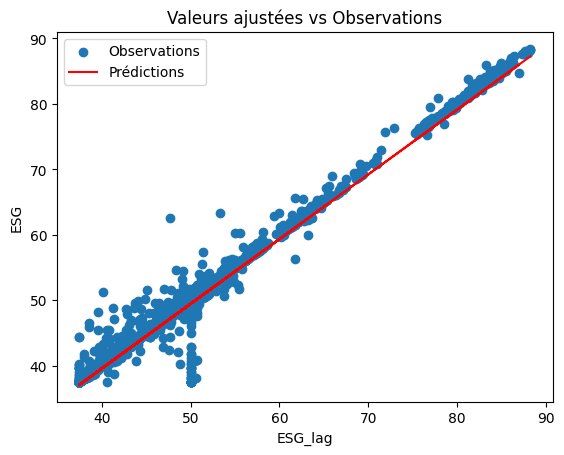

In [19]:
plt.scatter(df['ESG_lag'], df['ESG'], label='Observations')
plt.plot(df['ESG_lag'], df['ESG_star'], color='red', label='Prédictions')
plt.xlabel('ESG_lag')
plt.ylabel('ESG')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

In [20]:
# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['ESG'], df[['ESG_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_stage_one, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                    Model Comparison                    
                          Effets Fixes Effets Aléatoires
--------------------------------------------------------
Dep. Variable                      ESG               ESG
Estimator                     PanelOLS     RandomEffects
No. Observations                 12141             12141
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.9679            0.9998
R-Squared (Within)              0.9686            0.9685
R-Squared (Between)             0.9999            1.0000
R-Squared (Overall)             0.9996            0.9998
F-statistic                  3.592e+05         4.918e+07
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
ESG_lag                         0.9885            0.9999
                              (599.37)          (7012.8)
======================= ============== =================
Effects                        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:2623: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


### 2nde étape : Regression de phi_hat sur ESG_star

In [21]:
df['ESG_star_shift'] = df['ESG_star'].shift(1)
df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.422812  82.539668  93.292759  0.283145   
             2009-02-01   -0.231588  82.542735  93.560074  0.264490   
             2009-03-01   -0.235136  82.579781  90.820477  0.122571   
             2009-04-01   -0.456389  83.709127  91.262384  0.077381   
             2009-05-01   -0.460979  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447529  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448696  51.439231  50.000000 -0.928834   
             2023-02-01   -0.444969  51.435447  50.000000 -0.925788   
             2023-03-01   -0.447289  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451268  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  Rep_2SLS  \
idEntreprise Date                                                      
116          2009-01-01    76.417500        NaN        NaN       NaN   
             2009-02-01    80.227281  76.417500  65.342181  0.350383   
             2009-03-01    70.353190  80.227281  68.599804  0.367851   
             2009-04-01    68.060606  70.353190  60.156782  0.322577   
             2009-05-01    60.100608  68.060606  58.196466  0.312066   
...                              ...        ...        ...       ...   
18970        2022-12-01     0.000000   0.000000   0.000000  0.000000   
             2023-01-01     0.000000   0.000000   0.000000  0.000000   
             2023-02-01     0.000000   0.000000   0.000000  0.000000   
             2023-03-01     0.000000   0.000000   0.000000  0.000000   
             2023-04-01     0.000000   0.000000   0.000000  0.000000   

                         epsilon_hat   phi_hat    ESG_lag   ESG_star  \
idEntreprise Date                                                      
116          2009-01-01          NaN       NaN        NaN        NaN   
             2009-02-01     2.130369       NaN  82.539668  81.593674   
             2009-03-01    -0.587864 -2.718233  82.542735  81.596706   
             2009-04-01    -0.342286  0.245578  82.579781  81.633327   
             2009-05-01     0.349807  0.692093  83.709127  82.749730   
...                              ...       ...        ...        ...   
18970        2022-12-01   -12.055445 -1.169986  51.447034  50.857395   
             2023-01-01   -12.060286 -0.004841  51.443093  50.853499   
             2023-02-01   -12.061130 -0.000844  51.439231  50.849682   
             2023-03-01   -12.374818 -0.313688  51.435447  50.845941   
             2023-04-01   -12.378358 -0.003539  51.431738  50.842274   

                         ESG_star_shift  
idEntreprise Date                        
116          2009-01-01             NaN  
             2009-02-01             NaN  
             2009-03-01       81.593674  
             2009-04-01       81.596706  
             2009-05-01       81.633327  
...                                 ...  
18970        2022-12-01       50.861370  
             2023-01-01       50.857395  
             2023-02-01       50.853499  
             2023-03-01       50.849682  
             2023-04-01       50.845941  

[12212 rows x 13 columns]

In [22]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes
stage_two_fix = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=False)
res_stage_two_fix = stage_two_fix.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


##### Analyse de la regression :

In [23]:
print(res_stage_two_fix)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -2.5407
No. Observations:               12070   R-squared (Within):               0.0001
Date:                Sun, Apr 21 2024   R-squared (Overall):             -0.0133
Time:                        10:13:18   Log-likelihood                -2.379e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.2805
Entities:                          71   P-value                           0.2578
Avg Obs:                       170.00   Distribution:                 F(1,11998)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             1.2805
                            

-----------------------------------------------------------------------------------------------------------------------------
Voici une explication des principaux éléments de la sortie :

    R-squared (R-carré):
Le R-carré est une mesure de l'ajustement du modèle aux données. Ici, le R-carré est très faible, indiquant que le modèle n'explique qu'une très faible proportion de la variance de la variable dépendante.

    F-statistic (Statistique F):
La statistique F est utilisée pour tester la significativité globale du modèle. Dans ce cas, la valeur de la statistique F est faible, ce qui suggère que le modèle global n'est pas statistiquement significatif.

    Parameter Estimates (Estimations des paramètres):
Pour la variable ESG_star_shift, le coefficient estimé est de 0.0043 avec un écart-type de 0.0038. Cependant, le test de significativité t (T-stat) montre que ce coefficient n'est pas statistiquement significatif à un niveau de confiance de 95 %, car le p-valeur associé est supérieur à 0,05.

    F-test for Poolability (Test F pour la poolabilité):
Ce test évalue la pertinence d'inclure les effets d'entité dans le modèle. Ici, le p-valeur associé au test est supérieur à 0,05, ce qui suggère que l'inclusion des effets d'entité n'est pas statistiquement significative.

    Included Effects (Effets inclus):
Seuls les effets d'entité sont inclus dans le modèle. Cela signifie que le modèle prend en compte les différences systématiques entre les différentes entités de l'échantillon.

En résumé, le modèle PanelOLS n'explique pas de manière significative la variance de la variable dépendante phi_hat, et aucun des coefficients des variables indépendantes n'est statistiquement significatif. De plus, l'inclusion des effets d'entité dans le modèle n'est pas justifiée selon le test de poolabilité.

Pour essayer d'améliorer le R2, on jouant sur les paramètre entity_effect et time_effect :

In [24]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star sans effets fixes
stage_two_random = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=False, 
                        time_effects=False)
res_stage_two_random = stage_two_random.fit()

print(res_stage_two_random)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                     5.872e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0003
No. Observations:               12070   R-squared (Within):            4.352e-06
Date:                Sun, Apr 21 2024   R-squared (Overall):           5.872e-06
Time:                        10:13:18   Log-likelihood                -2.382e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0709
Entities:                          71   P-value                           0.7901
Avg Obs:                       170.00   Distribution:                 F(1,12069)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             0.0709
                            

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [25]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_fix_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=True, 
                        time_effects=True)
res_stage_two_fix_time = stage_two_fix_time.fit()

print(res_stage_two_fix_time)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -2.9057
No. Observations:               12070   R-squared (Within):               0.0001
Date:                Sun, Apr 21 2024   R-squared (Overall):             -0.0152
Time:                        10:13:18   Log-likelihood                -2.379e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.3489
Entities:                          71   P-value                           0.2455
Avg Obs:                       170.00   Distribution:                 F(1,11829)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             1.3489
                            

In [26]:
# Seconde étape: Régression de phi_hat sur ESG instrumenté par ESG_star avec effets fixes et effet dans le temps
stage_two_random_time = PanelOLS(dependent=df['phi_hat'], 
                        exog=df[['ESG_star_shift']],
                        entity_effects=False, 
                        time_effects=True)
res_stage_two_random_time = stage_two_random_time.fit()

print(res_stage_two_random_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:                phi_hat   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -2.2845
No. Observations:               12070   R-squared (Within):               0.0001
Date:                Sun, Apr 21 2024   R-squared (Overall):             -0.0119
Time:                        10:13:18   Log-likelihood                -2.382e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.2188
Entities:                          71   P-value                           0.0728
Avg Obs:                       170.00   Distribution:                 F(1,11899)
Min Obs:                       170.00                                           
Max Obs:                       170.00   F-statistic (robust):             3.2188
                            

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


----------------------------------------------------------------------------------------------------------------------
------------------------------------------ Que faire de plus ? -------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------

On a un R2 très très faible, on peut essayer de l'augmenter, mais comment ?

# Extensions

### Modèle à retards distribués

In [59]:
import warnings
from tqdm import tqdm
from linearmodels.panel.model import MissingValueWarning

warnings.filterwarnings('ignore', category=MissingValueWarning)

In [60]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

max_lags_con = 1  # A ajuster selon les besoins

# Générer les variables laggées
for lag in range(1, max_lags_con + 1):
    df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)

exog_vars = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# Regression avec fixed effects
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression de PFL sur Con_star_fix avec fixed effects
second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage_mult_lag = second_stage_mult_lag.fit()

# Ajouter fitted values et residuals 
df_mult_lag['Rep_2SLS'] = res_second_stage_mult_lag.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids

# Calcul du proxy du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Output the results
#res_second_stage_mult_lag

max_lags_esg = 4

# Generate lagged variables for ESG
for lag in range(1, max_lags_esg + 1):
    df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)

# Select exogenous variables for the model
exog_vars = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# First stage: Regression of ESG on multiple lagged ESG with fixed effects
first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res_first_stage = first_stage.fit()

# Add the fitted values to the dataframe
df_mult_lag['ESG_star'] = res_first_stage.fitted_values

# Shift ESG_star for use in the second stage
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star
second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage = second_stage.fit()

# Output the results
res_second_stage

Dep. Variable:,phi_hat,R-squared:,9.976e-05
Estimator:,PanelOLS,R-squared (Between):,-2.3633
No. Observations:,11857,R-squared (Within):,9.976e-05
Date:,"Sun, Apr 21 2024",R-squared (Overall):,-0.0123
Time:,11:40:03,Log-likelihood,-2.343e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.1758
Entities:,71,P-value,0.2782
Avg Obs:,167.00,Distribution:,"F(1,11785)"
Min Obs:,167.00,,
Max Obs:,167.00,F-statistic (robust):,1.1758


In [58]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

# Essayer tous les lags possibles pour 'ESG' et 'Con'
max_possible_lags = 10
best_r2 = -1
total_iterations = max_possible_lags ** 2

with tqdm(total=total_iterations, desc="Optimizing lags") as pbar:
    for max_lags_con in range(1, max_possible_lags + 1):
        for max_lags_esg in range(1, max_possible_lags + 1):

            # Màj barre de progression
            pbar.update(1)

            # Générer les variables laggées pour 'Con'
            for lag in range(1, max_lags_con + 1):
                df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)
            exog_vars_con = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
            df_mult_lag_exog_con = df_mult_lag[exog_vars_con]

            # Regression avec fixed effects pour 'Con'
            mod_con = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog_con, entity_effects=True, time_effects=True)
            res_con = mod_con.fit()
            df_mult_lag['Con_star_fix'] = res_con.fitted_values

            # Second stage: Regression de PFL sur Con_star_fix avec fixed effects
            second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
            res_second_stage_mult_lag = second_stage_mult_lag.fit()
            df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids
            df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

            # Générer les variables laggées pour 'ESG'
            for lag in range(1, max_lags_esg + 1):
                df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)
            exog_vars_esg = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
            df_mult_lag_exog_esg = df_mult_lag[exog_vars_esg]

            # First stage: Regression de ESG sur les multiple lagged ESG avec fixed effects
            first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog_esg, entity_effects=True, time_effects=True)
            res_first_stage = first_stage.fit()
            df_mult_lag['ESG_star'] = res_first_stage.fitted_values
            df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

            # Second stage: Regression de phi_hat sur shifted ESG_star
            second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
            res_second_stage = second_stage.fit()

            # Choisir le meilleur R-squared
            if res_second_stage.rsquared > best_r2:
                best_r2 = res_second_stage.rsquared
                best_lags_con = max_lags_con
                best_lags_esg = max_lags_esg

print(f'Best R-squared: {best_r2} achieved with {best_lags_con} lags for Con and {best_lags_esg} lags for ESG')

Optimizing lags:   0%|          | 0/100 [00:00<?, ?it/s]

Optimizing lags:   3%|▎         | 3/100 [00:05<02:51,  1.76s/it]


KeyboardInterrupt: 

### Variables instrumentales multiples

In [ ]:
df_mult_lag = pd.read_pickle('data_pannels.pkl')
df_mult_lag['Date'] = pd.to_datetime(df_mult_lag['Date'])
df_mult_lag['ESG'] = df_mult_lag['ESG'].str.replace(',', '.').astype(float)
df_mult_lag.set_index(['idEntreprise', 'Date'], inplace=True)

max_lags_con = 1  # A ajuster selon les besoins

# Générer les variables laggées
for lag in range(1, max_lags_con + 1):
    df_mult_lag[f'Con_lag{lag}'] = df_mult_lag.groupby(level=0)['Controverse'].shift(lag)

exog_vars = [f'Con_lag{lag}' for lag in range(1, max_lags_con + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# Regression avec fixed effects
mod = PanelOLS(dependent=df_mult_lag['Controverse'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res = mod.fit()
df_mult_lag['Con_star_fix'] = res.fitted_values

# Second stage: Regression de PFL sur Con_star_fix avec fixed effects
second_stage_mult_lag = PanelOLS(dependent=df_mult_lag['PFL'], exog=df_mult_lag[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage_mult_lag = second_stage_mult_lag.fit()

# Ajouter fitted values et residuals 
df_mult_lag['Rep_2SLS'] = res_second_stage_mult_lag.fitted_values
df_mult_lag['epsilon_hat'] = res_second_stage_mult_lag.resids

# Calcul du proxy du flux de communication environnementale
df_mult_lag['phi_hat'] = df_mult_lag.groupby(level=0)['epsilon_hat'].diff()

# Output the results
#res_second_stage_mult_lag

max_lags_esg = 4

# Generate lagged variables for ESG
for lag in range(1, max_lags_esg + 1):
    df_mult_lag[f'ESG_lag{lag}'] = df_mult_lag.groupby(level=0)['ESG'].shift(lag)

# Select exogenous variables for the model
exog_vars = [f'ESG_lag{lag}' for lag in range(1, max_lags_esg + 1)]
df_mult_lag_exog = df_mult_lag[exog_vars]

# First stage: Regression of ESG on multiple lagged ESG with fixed effects
first_stage = PanelOLS(dependent=df_mult_lag['ESG'], exog=df_mult_lag_exog, entity_effects=True, time_effects=True)
res_first_stage = first_stage.fit()

# Add the fitted values to the dataframe
df_mult_lag['ESG_star'] = res_first_stage.fitted_values

# Shift ESG_star for use in the second stage
df_mult_lag['ESG_star_shift'] = df_mult_lag['ESG_star'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star
second_stage = PanelOLS(dependent=df_mult_lag['phi_hat'], exog=df_mult_lag[['ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage = second_stage.fit()

# Output the results
res_second_stage

# Le reste du code

In [27]:
def get_user_date(start_date, end_date):
    # Prompt the user for a date
    user_date_str = input(f"Enter a date between {start_date} and {end_date} (format YYYY-MM): ")
    
    # Convert user input to a pandas Timestamp
    try:
        user_date = pd.to_datetime(user_date_str, format='%Y-%m')
        start_date = pd.to_datetime(start_date, format='%Y-%m')
        end_date = pd.to_datetime(end_date, format='%Y-%m')

        # Check if the date is within the range
        if start_date <= user_date <= end_date:
            print(f"Selected date: {user_date.strftime('%Y-%m')}")
            return user_date
        else:
            print("Date is out of range. Please try again.")
            return None
    except ValueError:
        print("Invalid date format. Please try again.")
        return None

# Example usage
get_user_date("2002-01", "2023-04")


Date is out of range. Please try again.


In [28]:
# On laisse l'utilisateur choisir une date
date_debut="2002-01"
date_fin="2023-04"
t = get_user_date(date_debut,date_fin)
t = pd.to_datetime(t, format='%Y-%m')
t_minus_1 = (t - pd.DateOffset(months=1)).strftime('%Y-%m')
print(t_minus_1)

# On recupère les scores des etp aux dates t et t-1
col_index = esg_data.columns.get_loc(t)
esge_t = esg_data.iloc[:, col_index]
col_index = esg_data.columns.get_loc(t_minus_1)
esge_t_minus_1 = esg_data.iloc[:, col_index]

Date is out of range. Please try again.


TypeError: unsupported operand type(s) for -: 'NoneType' and 'DateOffset'

In [ ]:
data = {
    'env_comm_score': env_comm_score, 
    'esge': esge_t
    'esge_past': esge_t_minus_1
    'esge_peer': np.random.uniform(0, 100, 100)  # 100 peer environmental scores in the same sector
}

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Define your variables
dependent = df['env_comm_score']
independent = df[['const']]  # Assuming you've added a constant term to your DataFrame
instrument = df['esge_past']  # Instrumenting esge with its past value
endogenous = df['esge']  # The variable you believe is endogenous

# Setup and run the 2SLS regression
model = IV2SLS(dependent, independent, endogenous, instrument).fit()

# Print model summary
print(model.summary)

# To instrument 'esge' with both its past value and peer scores, you might do:
instrument2 = df[['esge_past', 'esge_peer']]
model2 = IV2SLS(dependent, independent, endogenous, instrument2).fit()
print(model2.summary)
